<a href="https://colab.research.google.com/github/biaferre/projeto-clustering/blob/main/Projeto_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
1. [Initial settings](https://colab.research.google.com/drive/1To4frsGdAyqpbVPe3QVi3-KB53Hic-xl#scrollTo=VwXQ9m4iq8Vk&line=2&uniqifier=1): where imports and experimentations with the dataset are made, as well as standard scalling
2. [Elbow and PCA](https://colab.research.google.com/drive/1To4frsGdAyqpbVPe3QVi3-KB53Hic-xl#scrollTo=70CNq1ljyy_H&line=4&uniqifier=1): PCA and Elbow application in order to find optimal k value
3. [Kmeans](https://colab.research.google.com/drive/1To4frsGdAyqpbVPe3QVi3-KB53Hic-xl#scrollTo=yStUvtxU--dm): KMeans method application.
4. [Fuzzy cMeans](https://colab.research.google.com/drive/1To4frsGdAyqpbVPe3QVi3-KB53Hic-xl#scrollTo=xdas-Lkz_hqC&line=1&uniqifier=1): Fuzzy cMeans method application
5. [DBSCAN](https://colab.research.google.com/drive/1To4frsGdAyqpbVPe3QVi3-KB53Hic-xl#scrollTo=WTzIzs0v_pdR): DBSCAN method application.


#Initial settings

##Library imports


In [ ]:
# @title
# basic libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import random
!pip install -U scikit-fuzzy

import matplotlib.patches as patches
from IPython.display import display, HTML
from enum import Enum

In [ ]:
# extra sklearn and visualizing tools
!pip install scikit-learn-extra

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.datasets import load_credit


from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

##Dataset import

In [ ]:
wine_dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
                 header = None)


Separating target variables from the feature variables:

In [ ]:
target = wine_dataset.iloc[:,0:1]
df = wine_dataset.iloc[:,1:]

df.head() # checking data

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Experimenting with plots

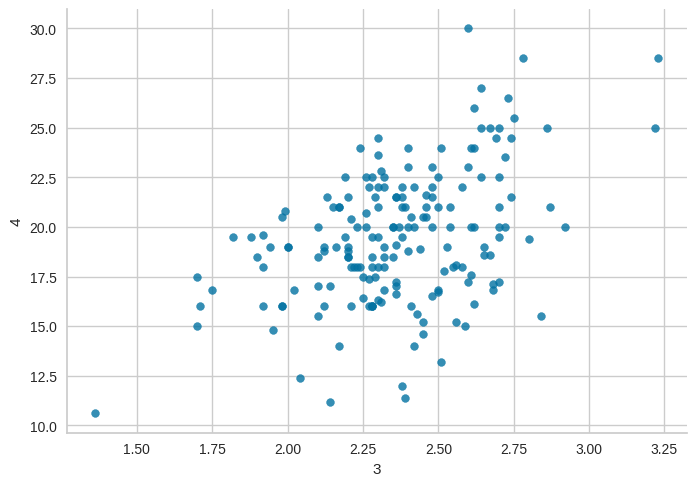

In [ ]:
# @title 3 vs 4

df.plot(kind='scatter', x=3, y=4, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

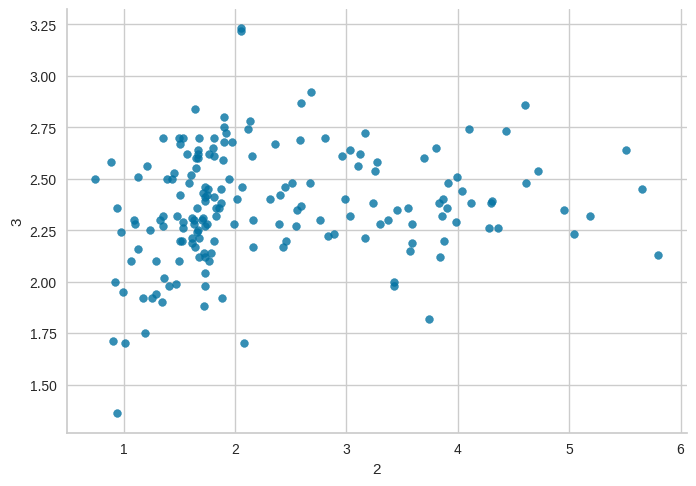

In [ ]:
# @title 2 vs 3

df.plot(kind='scatter', x=2, y=3, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## Scalling set
We use the StandardScaler from sklearn preprocessing here to standardize features in df.

In [ ]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874



#Elbow and PCA

Here, we'll find the optimal number for k using Elbow, which in turn uses PCA to reduce the model to the contributing variables.


Plain PCA:

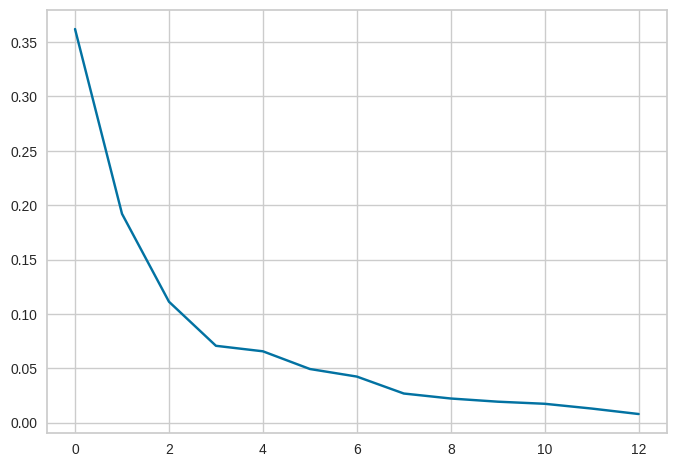

In [ ]:
pca = PCA(n_components = 13, random_state = 24)
full_df_tf = pca.fit_transform(df)
plt.plot(pca.explained_variance_ratio_)

Through the PCA graph, we know the first two variables are the most contributing.
We can restrict our dataframe to take only these contributing variables into account:

In [ ]:
df_tf = pd.DataFrame(full_df_tf[:,0:2]) # restricting to the first 2 columns
df_tf.head()

,0,1
0,3.316751,-1.443463
1,2.209465,0.333393
2,2.516740,-1.031151
3,3.757066,-2.756372
4,1.008908,-0.869831


Visualizing the Elbow score:

*P.S: I'll be using the "k-means++" initialization within the model sto elect the entroids instead of randomly.*

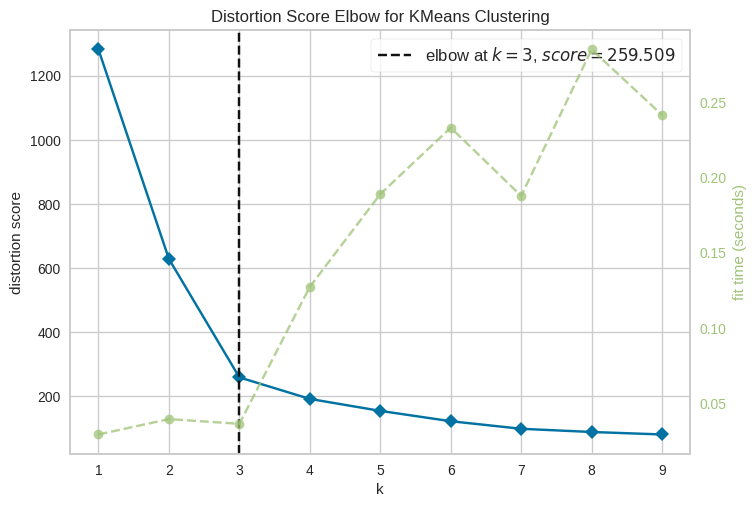

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans(n_init = 10,
               init = "k-means++")
elbow_visualizer = KElbowVisualizer(model, k=(1,10))

elbow_visualizer.fit(df_tf)
elbow_visualizer.poof()

Through this method, we're given 3 as the optimal value for k to be used in our application of kMeans.

In [ ]:
k_value = 3

## Initial visualization

Here we'll quickly use Seaborn to visualize how the data is scattered before clustering.

<Axes: xlabel='0', ylabel='1'>

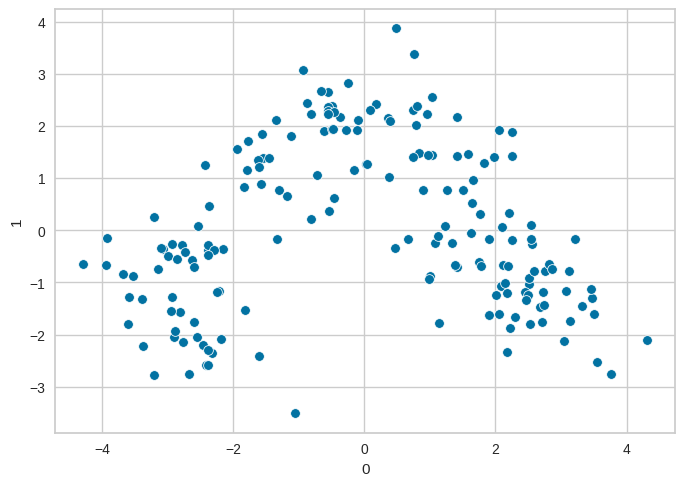

In [ ]:
sns.scatterplot(
    x = df_tf[0],
    y = df_tf[1])

# Kmeans

## Using Sklearn

### Implementation



Through the KMeans function skLearn.cluster provides we can easily visualize the clustering. We call it as such:

In [ ]:
kmeans = KMeans(n_clusters = k_value,
                init = "k-means++",
                n_init = 10)
kmeans.fit(df_tf)
km_labels = kmeans.fit_predict(df_tf)
print(km_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1
 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can now use Seaborn again to see the dataframe after the KMeans method.

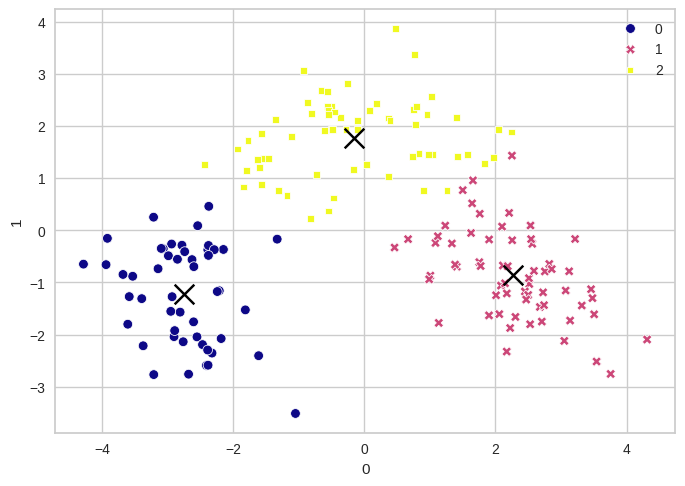

In [ ]:
sns.scatterplot(
    x = df_tf[0],
    y = df_tf[1],
    hue = km_labels,
    style = kmeans.labels_,
    palette = "plasma")

plt.scatter(
    kmeans.cluster_centers_[:,0],
    kmeans.cluster_centers_[:,1],
    marker = "x",
    s = 200,
    c = "black")

*[This](https://colab.research.google.com/drive/1To4frsGdAyqpbVPe3QVi3-KB53Hic-xl#scrollTo=PGoC1FwJBLgS&line=3&uniqifier=1) is how it was before the clustering.*

Another 2D visualization can be made with blobs.

X[:, 0] and X[:, 1] represent the Alcohol and Malic_Acid features respectively.

In [ ]:
df_array = df_tf

X, _ = make_blobs(n_samples=len(df_array), n_features=df_array.shape[1], random_state=42)

X = StandardScaler().fit_transform(X)

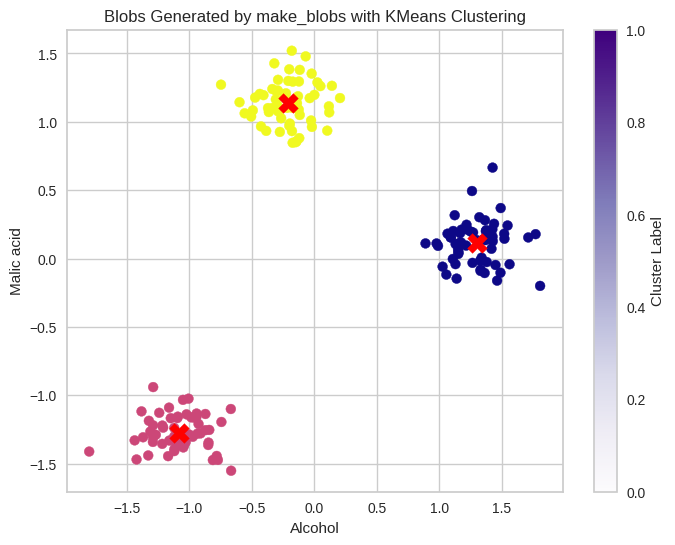

In [ ]:
blob_labels = kmeans.fit_predict(X) # second kmeaning for 2d plotting only

# plotting the blobs with colors based on cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c = blob_labels, s=50, cmap='plasma')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', c='red', s=200)
plt.xlabel('Alcohol')
plt.ylabel('Malic acid')
plt.title('Blobs Generated by make_blobs with KMeans Clustering')
plt.colorbar(label='Cluster Label')
plt.show()

### Purity Score

We'll use the purity score to calculate the homogeneity of clusters.

For that, we need a function to calculate the confusion matrix.

In [ ]:
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

purity_score(target, km_labels)

0.9662921348314607

###Sillhouette Score

We can use another score, the Sillhouette Score, to analyse the quality of the clustering made using Metrics imported from sklearn.

In [ ]:
metrics.silhouette_score(df_tf, km_labels)

0.5610505693103248

Visualizing its graph:

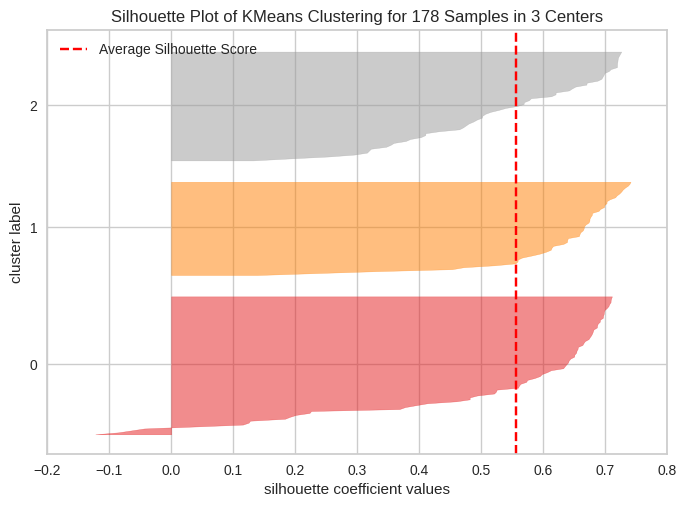

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 178 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(df_tf)
visualizer.poof()

## Without Sklearn

# Fuzzy cMeans

To implement the Fuzzy cMeans clustering, which uses fuzzy logic principles to cluster data, we can use the skfuzzy library.

In [ ]:
import skfuzzy as fuzz

We've observed 3 clusters when we executed kMeans, and even before, when we ran Seaborn on the unclustered data frame. However, we must consider a case where the data isn't clearly clustered.

So let's try clustering the data several times.

<Figure size 800x550 with 0 Axes>

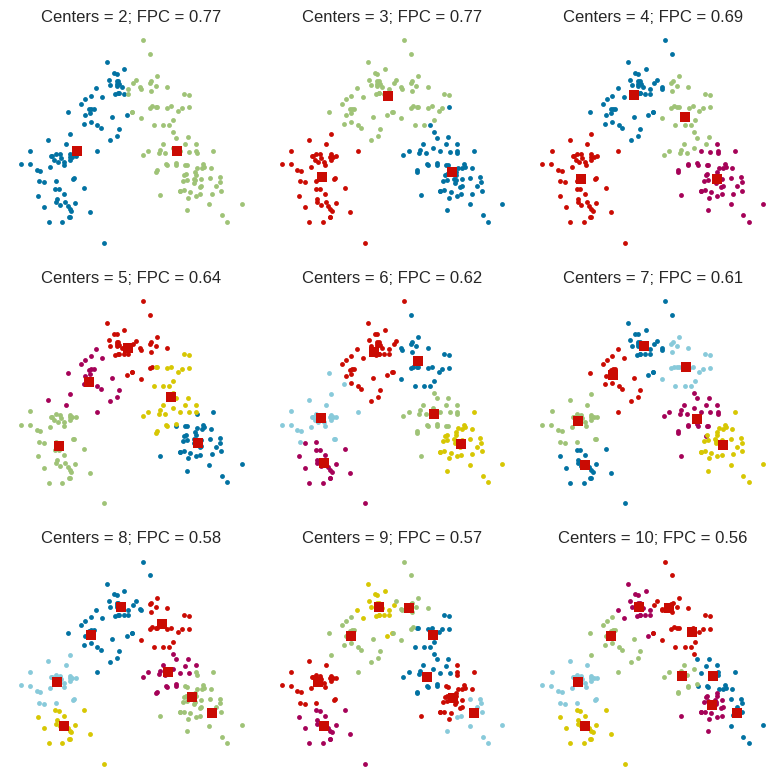

In [ ]:
xpts = df_tf[0].values
ypts = df_tf[1].values

plt.set_cmap('Purples')

fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts)) # saving values from most relevant columns
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)
    fpcs.append(fpc)

    cluster_membership = np.argmax(u, axis=0) # plotting for each point in set
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.')

    for pt in cntr: # marking center of clusters
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()
plt.show()

We've seen how the division works with many values for c. But we need to know which value is optimal, and that is what the Fuzzy Partition Coefficient is for.

The best number of centers for clustering is the one that corresponds to a fuzzy partition coefficient that is closer to 1. We can plot is below:

### Fuzzy Partition Coefficient

Text(0, 0.5, 'Fuzzy partition coefficient')

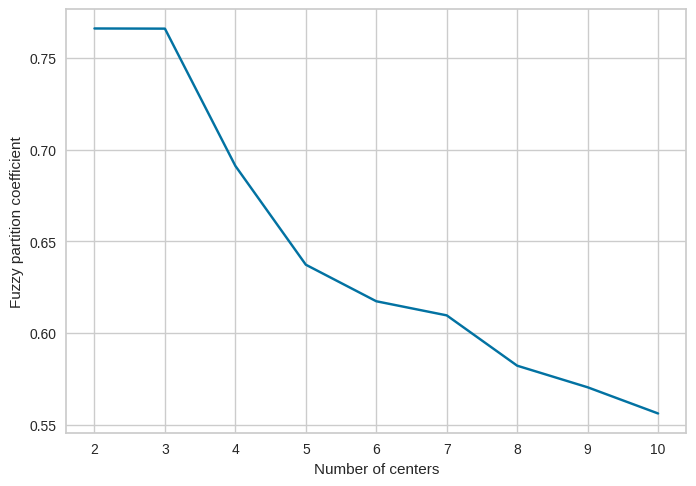

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

Now we can apply the clustering with c=3:

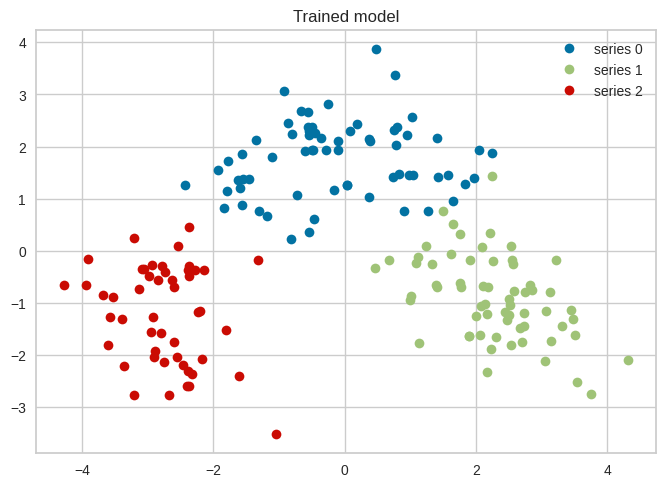

In [ ]:
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(3):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

In [ ]:
cluster_labels = u_orig.argmax(axis=0)

silhouette_score(alldata.T, cluster_labels)

0.5607148670939678

In [ ]:
purity_score(target, cluster_labels)

0.9719101123595506

###Prediction

Now we can check our trained model by creating mock data and classifying it according to our known centers

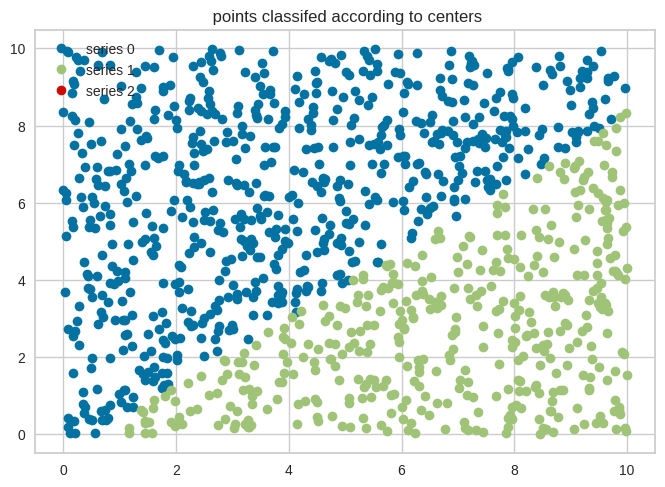

In [ ]:
newdata = np.random.uniform(0, 1, (1100, 2)) * 10

u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    newdata.T, cntr, 2, error=0.005, maxiter=1000)


cluster_membership = np.argmax(u, axis=0)
fig3, ax3 = plt.subplots()
ax3.set_title(' points classifed according to centers')
for j in range(3):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

# DBSCAN

Now we'll apply DBSCAN, a density-based clustering algorithm, and analyse its performance in relation to the previous methods.

First we must calculate epsilon. We may use the following function:

In [ ]:
def epsilon(data):

    # --- Calculate Nearest Neighbors ---
    neighbors=NearestNeighbors(n_neighbors=2)
    nbrs=neighbors.fit(data)
    distances, indices=nbrs.kneighbors(data)
    distances=np.sort(distances, axis = 0)
    distances_1=distances[:, 1]

    plt.plot(distances_1)

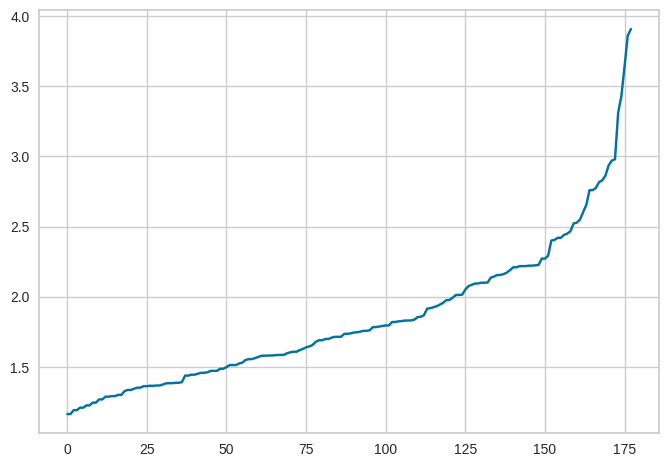

In [ ]:
epsilon(full_df_tf);

According to the graph, we can choose 2.3 as a good epsilon value.


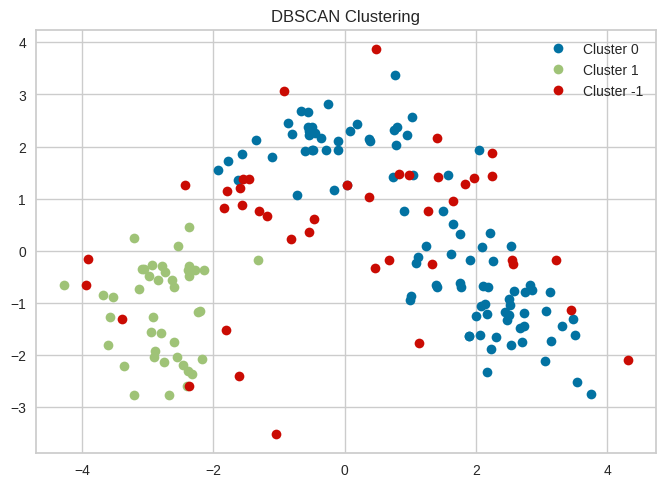

In [ ]:
dbscan = DBSCAN(eps=2.3)
y_fit = dbscan.fit_predict(full_df_tf)

fig2, ax2 = plt.subplots()
ax2.set_title('DBSCAN Clustering')
for label in set(y_fit):
    cluster_indices = np.where(y_fit == label)[0]
    ax2.plot(full_df_tf[cluster_indices, 0], full_df_tf[cluster_indices, 1], 'o', label=f'Cluster {label}')
ax2.legend()
plt.show()

Calculating the purity score for this method:

In [ ]:
purity_score(target, y_fit)

0.6910112359550562

Calculating the sillhouette score for this method:

In [ ]:
metrics.silhouette_score(df, y_fit)

0.17360049969363744